## Compare CatBoost in the case of binary class (Sell, Buy)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_catboost,
)

In [2]:
metric = "accuracy"
test_size = 199

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline CatBoost Classifier without new data + r

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

### Split dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_catboost(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=600,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-13 03:18:19,797] A new study created in memory with name: no-name-16038ebb-a42f-4975-bc8f-8fcb836c2e3d
[I 2024-02-13 03:18:23,106] Trial 0 finished with value: 0.5514677290836654 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0340502552561933, 'learning_rate': 0.014311356434970845, 'depth': 12, 'boosting_type': 'Plain', 'l2_leaf_reg': 10, 'min_data_in_leaf': 29, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.570693785711121}. Best is trial 0 with value: 0.5514677290836654.
[I 2024-02-13 03:18:31,292] Trial 1 finished with value: 0.5203505976095617 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.015800123412651683, 'learning_rate': 0.0038671982414664545, 'depth': 10, 'boosting_type': 'Ordered', 'l2_leaf_reg': 8, 'min_data_in_leaf': 3, 'bootstrap_type': 'Bernoulli', 'subsample': 0.4209114278422426}. Best is trial 0 with value: 0.5514677290836654.
[I 2024-02-13 03:18:33,682] Trial 2 finished with value: 0.5379219123505976 and parameters:

Number of finished trials: 121
Best trial:
  Value: 0.6584127490039842
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09339885476875055
    learning_rate: 0.07994836067091278
    depth: 11
    boosting_type: Ordered
    l2_leaf_reg: 4
    min_data_in_leaf: 21
    bootstrap_type: Bernoulli
    subsample: 0.795610153899076


In [11]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "rf",
            CatBoostClassifier(
                **trial.params
                | {
                    "used_ram_limit": "3gb",
                    "random_state": 1968,
                    "silent": True,
                }
            ),
        ),
    ]
)

In [12]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x130035cd0>)])

In [13]:
predictions = pipe.predict(X_test)

In [14]:
pipe.score(X_test, y_test)

0.5829145728643216

              precision    recall  f1-score   support

           0       0.55      0.92      0.68        98
           1       0.76      0.26      0.39       101

    accuracy                           0.58       199
   macro avg       0.66      0.59      0.53       199
weighted avg       0.66      0.58      0.53       199



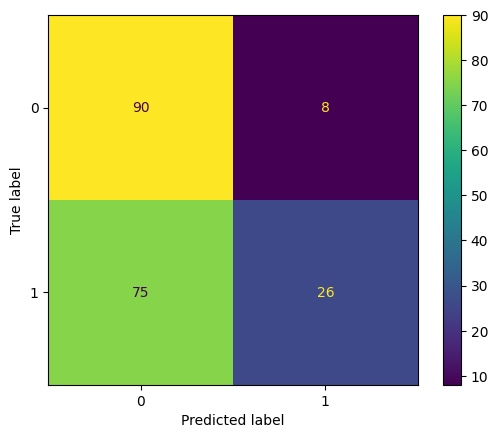

In [15]:
display_report(y_test, predictions)

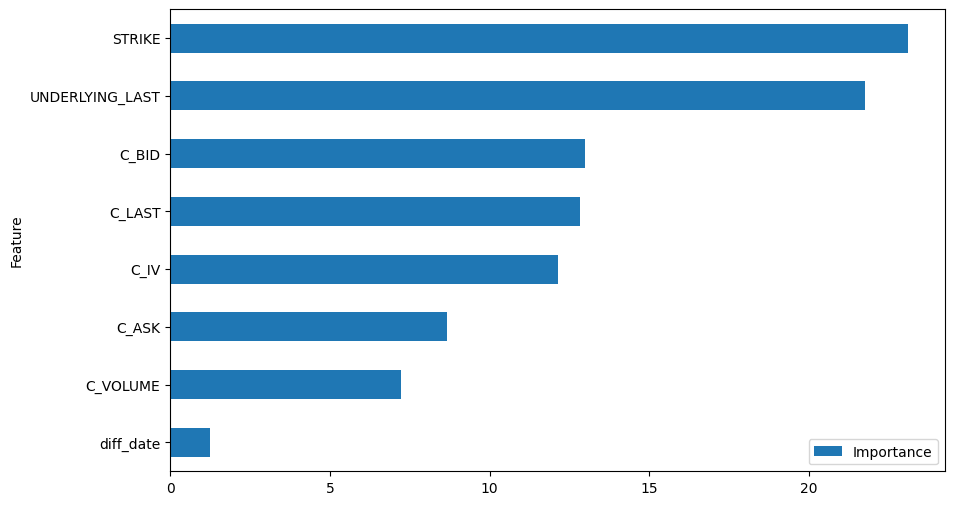

In [16]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [17]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [18]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [19]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,0,384.0,7.46,2023-01-27,405.679993,0.000000,14.219993,0.000000,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,18.179993,32.399985
2023-01-06,1,388.0,7.72,2023-01-27,405.679993,9.959993,9.959993,28.139985,42.359978
2023-01-09,0,388.0,7.46,2023-01-27,405.679993,0.000000,10.219993,28.139985,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,28.139985,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,242.549965,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,242.549965,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,242.549965,401.389886


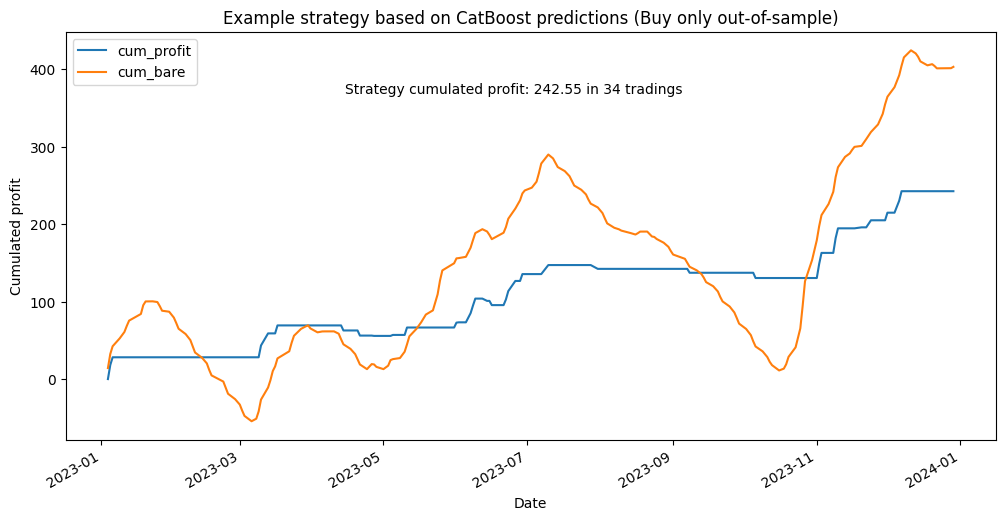

In [20]:
plot_strategy(strategy_df, "CatBoost", "(Buy only out-of-sample)")

## CatBoost with data from MC simulation and additional features

In [21]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [22]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_catboost(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=1200,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-13 03:28:23,797] A new study created in memory with name: no-name-3e7aed0a-8c2d-467e-ba16-3b003e88e0ca
[I 2024-02-13 03:28:32,605] Trial 0 finished with value: 0.5514741035856574 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.021214787553949135, 'learning_rate': 0.003386833771496364, 'depth': 8, 'boosting_type': 'Ordered', 'l2_leaf_reg': 6, 'min_data_in_leaf': 97, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.623268460847274}. Best is trial 0 with value: 0.5514741035856574.
[I 2024-02-13 03:28:36,489] Trial 1 finished with value: 0.6176860557768925 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04467707750453183, 'learning_rate': 0.0012063631811498133, 'depth': 8, 'boosting_type': 'Plain', 'l2_leaf_reg': 9, 'min_data_in_leaf': 63, 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.6176860557768925.
[I 2024-02-13 03:28:44,809] Trial 2 finished with value: 0.5770071713147411 and parameters: {'objective': 'Logloss', 'colsampl

Number of finished trials: 150
Best trial:
  Value: 0.7501928286852589
  Params: 
    objective: Logloss
    colsample_bylevel: 0.08172376192187038
    learning_rate: 0.031090804903513306
    depth: 8
    boosting_type: Plain
    l2_leaf_reg: 10
    min_data_in_leaf: 9
    bootstrap_type: MVS


In [25]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "rf",
            CatBoostClassifier(
                **study.best_params
                | {
                    "used_ram_limit": "3gb",
                    "eval_metric": "Accuracy",
                    "early_stopping_rounds": 50,
                    "random_state": 1968,
                    "silent": True,
                }
            ),
        ),
    ]
)

In [26]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x10bd371d0>)])

In [27]:
predictions = pipe.predict(X_test)

In [28]:
pipe.score(X_test, y_test)

0.6030150753768844

              precision    recall  f1-score   support

           0       0.58      0.67      0.63        98
           1       0.63      0.53      0.58       101

    accuracy                           0.60       199
   macro avg       0.61      0.60      0.60       199
weighted avg       0.61      0.60      0.60       199



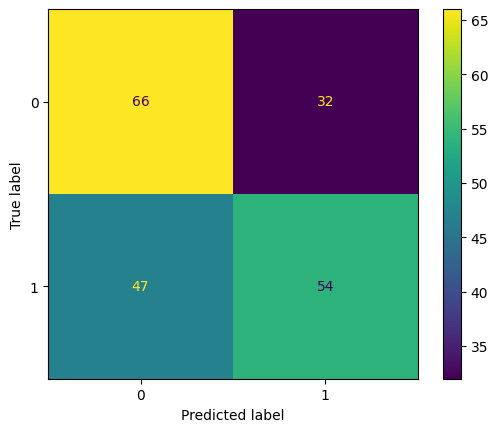

In [29]:
display_report(y_test, predictions)

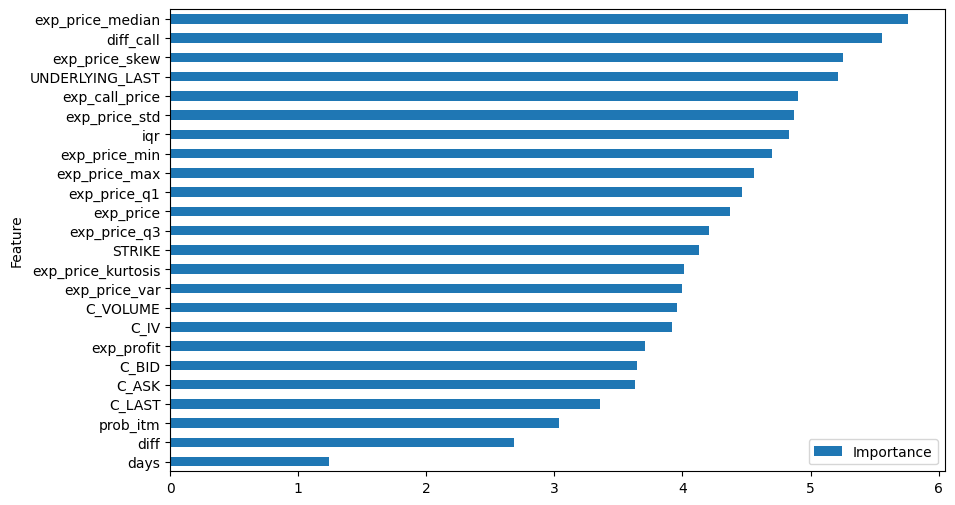

In [30]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [31]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [32]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [33]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,1,388.0,7.72,2023-01-27,405.679993,9.959993,9.959993,42.359978,42.359978
2023-01-09,1,388.0,7.46,2023-01-27,405.679993,10.219993,10.219993,52.579971,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,52.579971,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,362.419948,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,362.419948,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,362.419948,401.389886


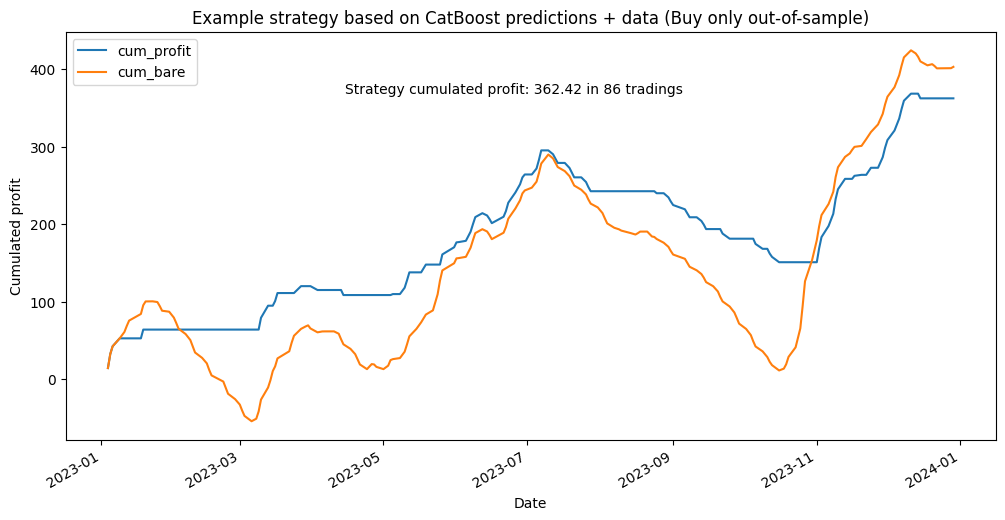

In [34]:
plot_strategy(strategy_df, "CatBoost", "+ data (Buy only out-of-sample)")

## Compare the two predictions

In [35]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [36]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,mmar_rf_pred_out
0,0,1
3,0,1
8,0,1
40,0,1
45,0,1
49,0,1
52,0,1
59,1,0
62,1,0
69,0,1


In [37]:
compare_df[mask_out].shape

(60, 2)

In [38]:
compare_df.sum(axis=0)

bare_rf_pred_out    34
mmar_rf_pred_out    86
dtype: int64